In [47]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from maria_specific_CNB_decay import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## n3 (parents) number density vs. redshift plot

(50, 100)
n3 today : 56.41881618075881
n3 at dec : 0.0009523708466748308


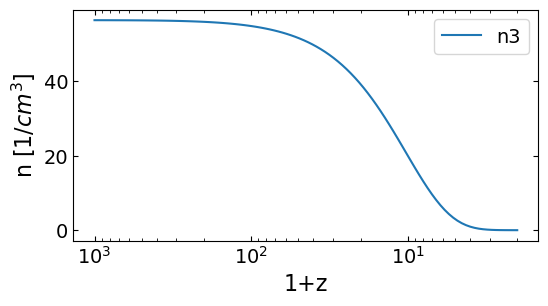

In [49]:
z_0, z_dec = 1., 1000.
z_range = jnp.logspace(jnp.log10(z_0+1), jnp.log10(z_dec+1), 100)-1

p_range = jnp.geomspace(0.01, 10, 50)*Params.T_CNB
redshifted_p = p_range[:, jnp.newaxis] * (1+z_range)

Gamma_test = 1e-16/Params.s
m_heavy = 0.1*Params.eV

n3_raw, _, _, n3_deriv_p_range = decay.n3_p_range(
    p=redshifted_p, 
    z=z_range, 
    Gamma=Gamma_test, 
    m_h=m_heavy, 
    args=Params())

print(n3_raw.shape)

# log integration
n3_redshifts = trap(n3_raw*redshifted_p, x=jnp.log(redshifted_p), axis=0)

cm3_unit = 1/Params.cm**3
# N0_cm3 = Params.N0/cm3_unit
N0_cm3 = 1

# n3_total = trap(n3_redshifts/cm3_unit, z_range)
# print(n3_total, jnp.sum(n3_redshifts/cm3_unit))
# n3_total = trap(n3_redshifts*z_range/cm3_unit, x=jnp.log(z_range))
# print(n3_total, jnp.sum(n3_redshifts/cm3_unit))

# Print & plot results.
print('n3 today :', jnp.max(n3_redshifts)/cm3_unit/N0_cm3)
print('n3 at dec :', jnp.min(n3_redshifts)/cm3_unit/N0_cm3)
fig, ax = plt.subplots(figsize=(6,3))
ax.semilogx(1+z_range, n3_redshifts/cm3_unit/N0_cm3, label='n3')
ax.set_xlabel('1+z')
ax.invert_xaxis()
ax.set_ylabel(r'n [$1/cm^3$]')
plt.legend()
plt.show()

## decay formula tests

(50, 100)
(100,)
500.35395872729316


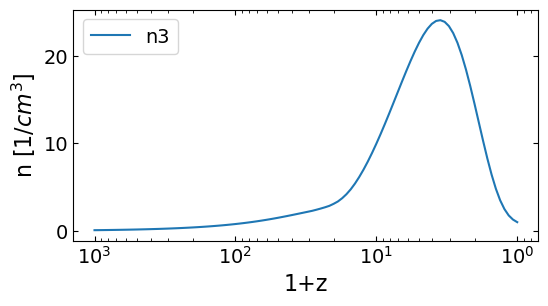

In [75]:
print(n3_deriv_p_range.shape)

# log integration
n3_deriv_redshifts = trap(n3_deriv_p_range*redshifted_p, x=jnp.log(redshifted_p), axis=0)
print(n3_deriv_redshifts.shape)

# log integration
n3_int = trap(n3_deriv_redshifts*(1+z_range), x=jnp.log(1+z_range))
print(n3_int/cm3_unit)

fig, ax = plt.subplots(figsize=(6,3))
ax.semilogx(1+z_range, n3_deriv_redshifts/cm3_unit/N0_cm3, label='n3')
ax.set_xlabel('1+z')
ax.invert_xaxis()
ax.set_ylabel(r'n [$1/cm^3$]')
plt.legend()
plt.show()

## own derivative

(50, 100) (100,)
17.947900137929835


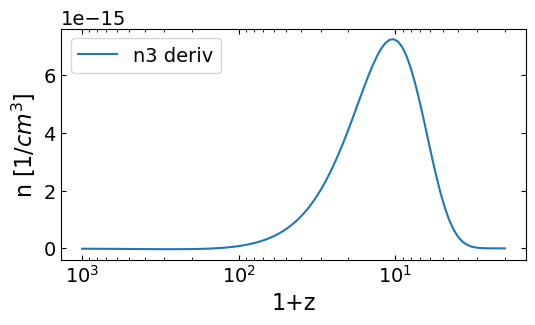

In [46]:
def n3_deriv_own(p_in, z_in, Gamma_in, m_h_in, args):
    
    # print(p_in.shape, z_in.shape)

    ### ============================== ###
    ### Parent neutrino number density ###
    ### ============================== ###

    n3_raw, _, _, _ = decay.n3_p_range(
        p=p_in, 
        z=z_in, 
        Gamma=Gamma_in, 
        m_h=m_h_in, 
        args=Params())


    ### ================================= ###
    ### New terms appearing in derivative ###
    ### ================================= ###
    
    T1 = 3/(1+z_in)
    T2 = 1/(jnp.exp(-p_in/(args.T_CNB*(1+z_in))) + 1) * p_in/(args.T_CNB*(1+z_in)**2)
    
    T_Xi = decay.Xi(z_in, p_in, m_h_in, args=args)
    T_dXi_1 = decay.CALC_Hubble_rate(z_in, args)*(1+z_in)
    T_dXi_2 = jnp.sqrt((1+z_in)**2 + jnp.square(m_h_in*(1+z_in)/p_in))
    T_dXi = (1+z_in)/(T_dXi_1*T_dXi_2)


    def T_dXi_int(z_prime, z_dXi, p_dXi, m_h_dXi, args):

        numer = (1+z_dXi)*m_h_dXi**2/p_dXi**2
        denom1 = decay.CALC_Hubble_rate(z_prime, args)*(1+z_prime)
        denom2 = jnp.power((1+z_prime)**2 + jnp.square(m_h_dXi*(1+z_dXi)/p_dXi), 3/2)

        return numer/(denom1*denom2)

    T_dXi_int()


    T_Gamma_pre = Gamma_in*m_h_in/p_in
    T_Gamma = T_Xi - T_dXi

    new_terms_combined = -T1 + T2 -(T_Gamma_pre*T_Gamma)

    return n3_raw * new_terms_combined


n3_deriv = n3_deriv_own(
    p_in=redshifted_p, 
    z_in=z_range, 
    Gamma_in=Gamma_test, 
    m_h_in=m_heavy, 
    args=Params())
# print(n3_deriv.shape)


n3_deriv_int_along_p = trap(n3_deriv*redshifted_p, x=jnp.log(redshifted_p), axis=0)
# n3_deriv_int_along_p = trap(n3_deriv, x=redshifted_p, axis=0)
# print(n3_deriv_int_along_p.shape)

n3_int_along_z = trap(n3_deriv_int_along_p, z_range)
print(n3_int_along_z/cm3_unit)

fig, ax = plt.subplots(figsize=(6,3))
ax.semilogx(1+z_range, n3_deriv_int_along_p, label='n3 deriv')
ax.set_xlabel('1+z')
ax.invert_xaxis()
ax.set_ylabel(r'n [$1/cm^3$]')
plt.legend()
plt.show()